### 1. Import Libraries and Datasets

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import warnings
from nltk import word_tokenize, pos_tag, FreqDist, SnowballStemmer
from nltk.corpus import wordnet as wn, stopwords
from gensim import corpora, models
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from wordcloud import WordCloud
from nltk.util import ngrams
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

current_directory = os.getcwd()
print("Current Directory:", current_directory)
sys.path.append("c:/Users/Michael/Documents/GitHub/EBAC")

from commonFunctions import hist

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

C:\Users\Michael\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current Directory: c:\Users\Michael\Documents\GitHub\EBAC\Modelling\Text Analytics


In [2]:
# From dataProcessing.py!!!! (Pulling var from other file doesn't seem to work, dk why)

userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')
userComments3 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (200-300k).csv')

userComments3['Unnamed: 0'] = userComments3['Unnamed: 0'].astype('float64')
userComments3['Userscore'] = userComments3['Userscore'].astype('float64')

userComments = pd.concat([userComments1, userComments2, userComments3], axis = 0)
userComments.drop(columns = 'Unnamed: 0', inplace = True)
userComments.dropna(how = 'all', inplace = True)

In [3]:
# From createMainTable.py!!!! (Pulling var from other file doesn't seem to work, dk why)

main = pd.read_excel('c:/Users/Michael/Documents/GitHub/EBAC/dataProcessing/outputOfJoinedTablexceptReleaseDate19862023.xlsx', sheet_name= 'Sheet1')
gameScore = pd.read_excel('c:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metascore-video-games-1986-2023.xlsx', sheet_name='Sheet1')

### 2. Data Preparation

In [4]:
userComments.Platform.unique()

platformMap = {
'Nintendo64': 'Nintendo',
'GameBoyAdvance': 'Nintendo',
'3DS': 'Nintendo',
'DS': 'Nintendo',
'Wii': 'Nintendo',
'Switch': 'Nintendo',
'WiiU': 'Nintendo',
'GameCube': 'Nintendo',
'PlayStation': 'PlayStation',
'PlayStation3': 'PlayStation',
'PlayStation2': 'PlayStation',
'PlayStation4': 'PlayStation',
'PlayStationVita': 'PlayStation',
'PSP': 'PlayStation',
'Xbox360': 'Xbox',
'Xbox': 'Xbox',
'XboxOne': 'Xbox',
'PC': 'PC',
'Dreamcast': 'Others',
'not specified': 'Others'
}

userComments['platformCondensed'] = userComments.Platform.map(platformMap)

In [5]:
filter_list = ["would", "could", "left", "right", "a.m.", "p.m.", "'s", "! ! !", "...", ":", ";", "n't",
              "game", "games", "play", "fun", "much", "one", "great", "perfect", "time", "year", "lot", "thing", "etc",
              "hour", "hours", "way", "ways", "everything", "anything", "thing", "things", "review", "reviews", "year", "years",
              "feel", "feels", "thing", "nothing", "problem", "end", "begin", "kind", "piece", "work", "call", "anyone",
              "minute", "minutes", "waste", "crap", "garbage", "masterpiece"]

def preprocess_text(tokens, needtokenizeBoolean = True, grams = False,  ngramsNumber = 2, furtherPreProcessNgrams = False):
    
    if needtokenizeBoolean:
        tokens = nltk.word_tokenize(tokens)
        if grams:
            tokens = list(ngrams(tokens, ngramsNumber))
    if grams:
        tokens = [' '.join(gram) for gram in tokens]
        if furtherPreProcessNgrams == False:
            return tokens

    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords.words('english') + filter_list]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if not t.isnumeric()]
    # tokens = [SnowballStemmer('english').stem(t) for t in tokens]
    tokens = [nltk.WordNetLemmatizer().lemmatize(w) for w in tokens]

    return tokens

In [6]:
userComments.shape

(283983, 6)

In [7]:
userCommentsTEST = userComments.sample(283983).copy()

In [8]:
userCommentsTEST.Userscore.value_counts().sort_index(ascending = False)

Userscore
10.0    112531
9.0      53489
8.0      30271
7.0      17052
6.0      12036
5.0      10113
4.0       7952
3.0       7118
2.0       5983
1.0       7318
0.0      20120
Name: count, dtype: int64

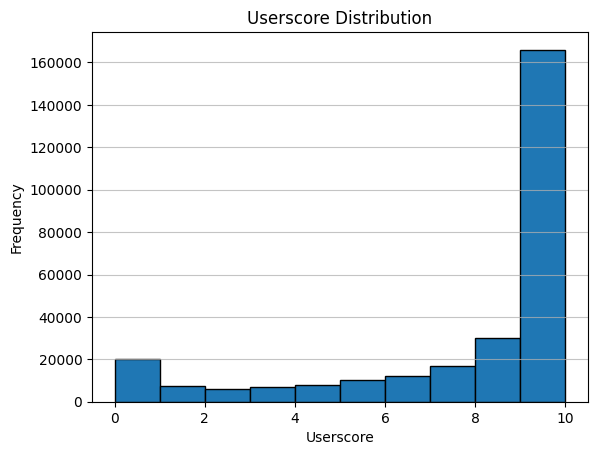

In [9]:
hist(userCommentsTEST, 'Userscore')

In [10]:
# Assumption: Game creators will want to focus on problems where they can fix and do better than improving what's already good (more weights on low userscores)

userCommentsTESTNotNull = userCommentsTEST[userCommentsTEST.Comment.notnull()]

userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore > 9, 'scoreBin'] = 'High'
userCommentsTESTNotNull.loc[(userCommentsTESTNotNull.Userscore >= 3) & (userCommentsTESTNotNull.Userscore <= 9), 'scoreBin'] = 'Medium'
userCommentsTESTNotNull.loc[userCommentsTESTNotNull.Userscore < 3, 'scoreBin'] = 'Low'

userCommentsTESTHigh = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'High']
userCommentsTESTLow = userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin == 'Low']

In [11]:
platformCondensed_list = list(userCommentsTESTNotNull[userCommentsTESTNotNull.scoreBin != 'Medium'].platformCondensed.unique())
userCommentsTESTExtreme_list = [userCommentsTESTHigh, userCommentsTESTLow]

In [12]:
df = userComments[userComments.platformCondensed != 'Others'].copy()

In [13]:
df.drop(columns = 'Platform', inplace = True)

In [14]:
df.rename(columns = {'platformCondensed': 'Platform'}, inplace = True)

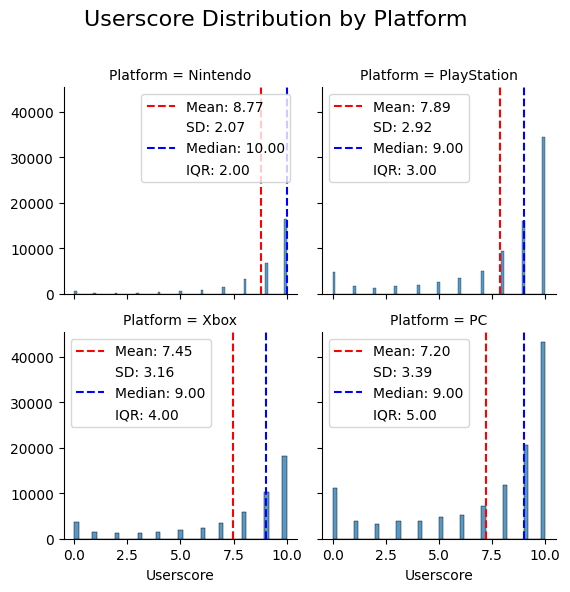

In [15]:
# Create a facet grid with Seaborn
g = sns.FacetGrid(df, col='Platform', col_wrap=2)
g.map(sns.histplot, 'Userscore', kde=False)

# Add labels for mean, median, SD, and IQR
for platform, ax in zip(df['Platform'].unique(), g.axes):
    platform_data = df[df['Platform'] == platform]['Userscore']
    mean = platform_data.mean()
    median = platform_data.median()
    std_dev = platform_data.std()
    iqr = platform_data.quantile(0.75) - platform_data.quantile(0.25)
    
    ax.axvline(mean, color='red', linestyle='dashed', label=f'Mean: {mean:.2f}')
    ax.axvline(std_dev, color='green', linestyle='dashed', alpha= 0, label=f'SD: {std_dev:.2f}')
    ax.axvline(median, color='blue', linestyle='dashed', label=f'Median: {median:.2f}')
    ax.axvline(iqr, color='orange', linestyle='dashed', alpha = 0, label=f'IQR: {iqr:.2f}')
    ax.legend()

# Adjust plot aesthetics
g.set_axis_labels('Userscore', '')
g.fig.suptitle('Userscore Distribution by Platform', fontsize=16)
g.set(ylim=(0, None))

# Show the plot
plt.subplots_adjust(top=0.85)
plt.show()

# distribution of userscores are generally similar across various platforms (join by just title with MAIN?)

In [16]:
title_counts = userComments.groupby('Title')['Comment'].count().reset_index().sort_values(by = 'Comment', ascending = False).head(10)
title_platform_counts = userComments.groupby(['Title', 'platformCondensed'])['Comment'].count().reset_index()
title_platform_counts = pd.merge(title_counts[['Title']], title_platform_counts, how = 'left', on = 'Title')

df = title_platform_counts.copy()

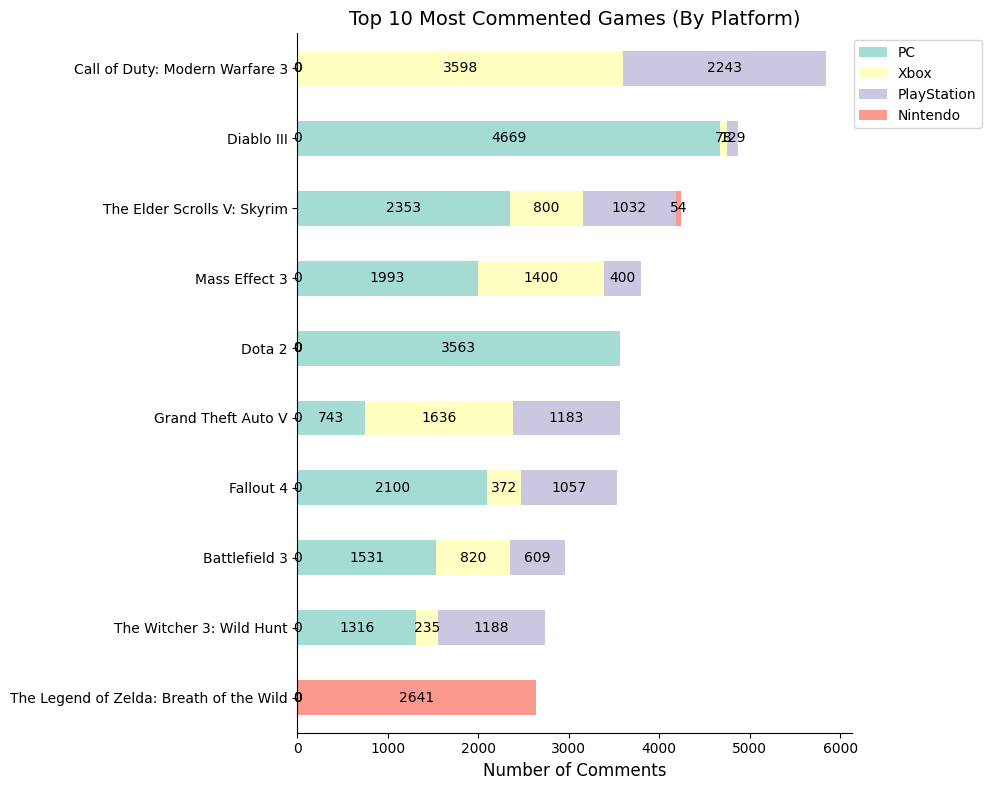

In [19]:
# Pivot the data to create a DataFrame suitable for a stacked bar chart
pivot_df = df.pivot(index='Title', columns='platformCondensed', values='Comment')

# Sort by the total number of comments in descending order
sorted_titles = pivot_df.sum(axis=1).sort_values().index
pivot_df = pivot_df.loc[sorted_titles]

# Sort platforms by the total number of comments
sorted_platforms = pivot_df.sum().sort_values(ascending=False).index
pivot_df = pivot_df[sorted_platforms]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Use a Seaborn color palette for better colors
colors = sns.color_palette("Set3", n_colors=len(pivot_df.columns))

# Plot the stacked bar chart
bars = pivot_df.plot(kind='barh', stacked=True, color=colors, alpha=0.8, ax=ax)

ax.set_xlabel('Number of Comments', fontsize=12)
ax.set_ylabel('', fontsize=12)  # Remove the Y-axis label
ax.set_title('Top 10 Most Commented Games (By Platform)', fontsize=14)
ax.spines[['right', 'top']].set_visible(False)

# Add data labels to the bars
for container in bars.containers:
    ax.bar_label(container, fmt='%.0f', label_type='center', fontsize=10, color='black')

# Add legends
ax.legend(loc='upper left', bbox_to_anchor=(0.99, 1), labels=sorted_platforms, fontsize=10)

plt.tight_layout()
plt.show()

# there are uneven distribution of platform comments per game (but that does not mean that within each platform, the comment sentiments are different) ..
# .. should we generalise that the comments are similar per platform (then join by just title with MAIN?)


### 3. WordNet and Q&A method

In [10]:
def tagging_QA(df, colName, top = 10, wnWord = None, question = None, stopWordsRemoval = True, features_improvements = "Features/ Improvements"):
    
    wnl = nltk.WordNetLemmatizer()
    
    if wnWord != None:
        ss = wn.synsets(wnWord)[0]
        hyps = list(set([w for s in ss.closure(lambda s:s.hyponyms())
                        for w in s.lemma_names()]))
        wn_list = [w for w in hyps if "_" not in w]

    if question != None:
        qa = pipeline("question-answering")
        for index, value in enumerate(df[colName]):
            result = qa(question = question, context=value)
            df.loc[df.index == index, 'Answer'] = result['answer']

        df['Answer'] = df.Answer.apply(lambda x: list(set([w.lower() for w in word_tokenize(x)])))
        if wnWord != None:
            series = df.Answer.apply(lambda x: [noun for noun in x if noun in wn_list])
        else:
            series = df.Answer
            
    if question == None:
        series = df[colName].apply(lambda x: list(set([w.lower() for w in word_tokenize(x)])))

    series = [c for l in series for c in l]
    if stopWordsRemoval == True:
        series = [w for w in series if w not in stopwords.words('english')]
    series = [t for t in series if t not in string.punctuation]
    series = [t for t in series if not t.isnumeric()]
    series = [wnl.lemmatize(w) for w in series]
    fd= FreqDist(series)
    wc = WordCloud(background_color="white").generate_from_frequencies(fd)
    plt.suptitle(f"{features_improvements}", fontsize = 20, x = 0.5, y = 0.85, fontweight = 'bold', fontname = 'Calibri') 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    displayList = []
    for x,y in fd.most_common(top):
        displayList.append((x, round(y, 2)))

    plt.show()
    print(displayList)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


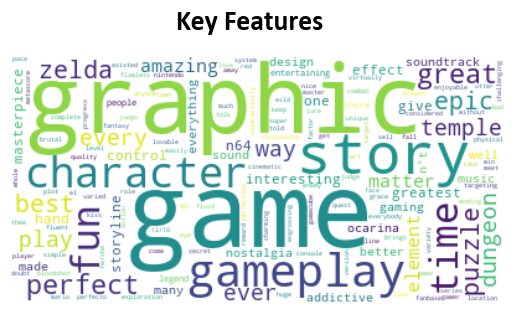

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


[('game', 15), ('graphic', 12), ('story', 12), ('gameplay', 7), ('character', 6), ('fun', 5), ('time', 5), ('perfect', 5), ('great', 5), ('epic', 4)]


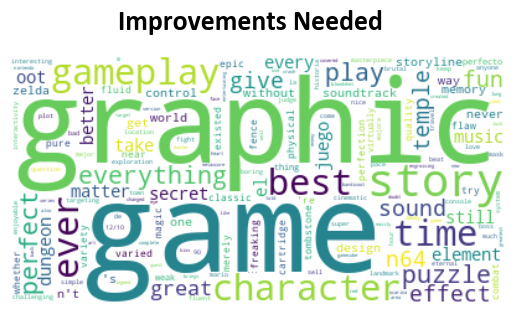

[('game', 15), ('graphic', 14), ('story', 9), ('ever', 5), ('gameplay', 5), ('best', 5), ('character', 5), ('time', 5), ('everything', 4), ('puzzle', 4)]


In [11]:
# Plan: To use Q&A as 1st layer filter to split sentiments, then find 'features' and 'improvements' libraries in the context of Games on WordNet as a 2nd filter to confirm the 'features' and 'improvements'.
# However, there is no such libraries on WordNet. Hence, have to reply just on our 1st layer, which is Q&A.
# Hypothesis: If the sentiments drawn from both questions are not the same, it means that Q&A method is able to discern key features vs. main improvements well, and may be used. Else, cannot be used.
# Result: The sentiments from 'features' and 'improvements' are similar (e.g. 'best', 'fun', 'perfect' for both), hence Q&A method can't be used too and have to explore other options.

questions = ['What are the best features of the game?', 'What are main improvements needed for the game?']
for question in questions:
    if question == 'What are the best features of the game?':
        features_improvements = 'Key Features'
    else:
        features_improvements = 'Improvements Needed'
    tagging_QA(userComments[userComments.Comment.notnull()], 'Comment', top = 10, wnWord = None, stopWordsRemoval = True, question = question, features_improvements = features_improvements)

### 4. Topic Modelling and TF-IDF method

In [19]:
for df in userCommentsTESTExtreme_list:

    documents = df['Comment'].apply(preprocess_text)

    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_below=2, no_above=0.8)

    corpus = [dictionary.doc2bow(doc) for doc in documents]
    tfidf = models.TfidfModel(corpus)
    tfidf_corpus = tfidf[corpus]

    lda = models.LdaModel(tfidf_corpus, num_topics=3, id2word=dictionary, chunksize=128, passes=10, random_state=10)
    print(f"{df.scoreBin.max()} Score:\n{lda.show_topics()}")
    # Are we able to string the words in each group to form a consistent topic (e.g. gameplay/ graphic/ storyline)?
    # Hypothesis: Cannot, the words consist of diff meanings.
    # Result: Truly cannot, and some of the groups gave gibberish words.
    # Therefore, we cannot use topic modelling/ clustering.

    if df.scoreBin.max() == 'High':
        dict = {0: 'placeholder1', 1: 'placeholder2', 2: 'placeholder3'}
        doc_topics = lda.get_document_topics(tfidf_corpus)
        top_topic = [max(t, key=itemgetter(1))[0] for t in doc_topics]
        topics_perDoc = [dict[t] for t in top_topic]
        labels, counts = np.unique(topics_perDoc, return_counts=True)
        print(labels)
        print(f"{counts}\n\n")

    elif df.scoreBin.max() == 'Low':
        dict = {0: 'placeholder1', 1: 'placeholder2', 2: 'placeholder3'}
        doc_topics = lda.get_document_topics(tfidf_corpus)
        top_topic = [max(t, key=itemgetter(1))[0] for t in doc_topics]
        topics_perDoc = [dict[t] for t in top_topic]
        labels, counts = np.unique(topics_perDoc, return_counts=True)
        print(labels)
        print(f"{counts}\n\n")

High Score:
[(0, '0.002*"gamecube" + 0.002*"metroid" + 0.002*"owns" + 0.002*"decade" + 0.002*"fifa" + 0.002*"1.6" + 0.001*"soccer" + 0.001*"sexy" + 0.001*"pe" + 0.001*"в"'), (1, '0.005*"de" + 0.004*"e" + 0.004*"sweet" + 0.004*"que" + 0.003*"un" + 0.002*"la" + 0.002*"juego" + 0.002*"comment" + 0.002*"en" + 0.002*"jogo"'), (2, '0.006*"best" + 0.005*"ever" + 0.004*"played" + 0.004*"good" + 0.004*"story" + 0.004*"like" + 0.003*"graphic" + 0.003*"amazing" + 0.003*"really" + 0.003*"get"')]
['placeholder1' 'placeholder2' 'placeholder3']
[ 16  37 947]


Low Score:
[(0, '0.004*"volvo" + 0.002*"в" + 0.002*"hat" + 0.002*"не" + 0.001*"как" + 0.001*"wer" + 0.001*"а" + 0.001*"что" + 0.001*"halloween" + 0.001*"микротранзакции"'), (1, '0.003*"like" + 0.003*"good" + 0.002*"money" + 0.002*"get" + 0.002*"bad" + 0.002*"give" + 0.002*"even" + 0.002*"player" + 0.002*"story" + 0.002*"boring"'), (2, '0.003*"pokemon" + 0.002*"uplay" + 0.002*"blade" + 0.001*"batmobile" + 0.001*"blacklist" + 0.001*"pet" + 0.000*

### 5. POS Tagging and TF-IDF method

In [12]:
def wc(df, columnName, preProcessingFunctionBoolean = True, tfidfVectorizerBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7, countVectorizerBinary = True,
       nounTaggingBoolean = False, universalNounTagsetBoolean = False, ngrams = False, ngramsNumber = 2, furtherPreProcessNgrams = False,
       top = 10, features_improvements = 'Word Cloud', platform = 'All', titleFontSize = 20):

    if preProcessingFunctionBoolean == True & ngrams == True:
        if tfidfVectorizerBoolean == True:
            if furtherPreProcessNgrams == True:
                tdm = TfidfVectorizer(tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber, furtherPreProcessNgrams = True),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if furtherPreProcessNgrams == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber, furtherPreProcessNgrams = True),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = lambda text: preprocess_text(text, grams = True, ngramsNumber=ngramsNumber),
                                      min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])
    
    if nounTaggingBoolean == True and ngrams == False:
        noun_list = []
        for value in df[columnName]:
            if universalNounTagsetBoolean == True:
                tagged_value = pos_tag(word_tokenize(value), tagset='universal')
                noun = [word for word, tag in tagged_value if tag == 'NOUN']
            else:
                tagged_value = pos_tag(word_tokenize(value))
                noun = [word for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']
            noun_list.append(noun)
        df['Text_NounOnly'] = noun_list
        if preProcessingFunctionBoolean == True:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: preprocess_text(tokens = x, needtokenizeBoolean = False))
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        else:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        if tfidfVectorizerBoolean == True:
            tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df['Text_NounOnly'])
        
    if nounTaggingBoolean != True and ngrams == False:
        if tfidfVectorizerBoolean == True:
            if preProcessingFunctionBoolean == True:
                tdm = TfidfVectorizer(tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = TfidfVectorizer(min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        else:
            if preProcessingFunctionBoolean == True:
                tdm = CountVectorizer(binary = countVectorizerBinary, tokenizer = preprocess_text, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
            else:
                tdm = CountVectorizer(binary = countVectorizerBinary, min_df = vectorizerMinDf, max_df = vectorizerMaxDf)
        tdmMatrix = tdm.fit_transform(df[columnName])

    array = tdmMatrix.toarray()
    feature_names = tdm.get_feature_names_out()
    word = dict(zip(feature_names, array.sum(axis=0)))
    fd = FreqDist(word)
    wc = WordCloud(background_color="white").generate_from_frequencies(fd)
    plt.figure()
    plt.suptitle(f"{features_improvements} ({platform})", fontsize = titleFontSize, x = 0.5, y = 0.85, fontweight = 'bold', fontname = 'Calibri') 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    displayList = []
    for x,y in fd.most_common(top):
        displayList.append((x, round(y, 2)))

    plt.show()
    print(displayList)

In [13]:
for platform in platformCondensed_list:
    for df in userCommentsTESTExtreme_list:
        print(f"{platform}, {df.reset_index().scoreBin[0]} Userscore; No. of comments: {df[df.platformCondensed == platform].shape[0]}")

Xbox, High Userscore; No. of comments: 18096
Xbox, Low Userscore; No. of comments: 6371
PlayStation, High Userscore; No. of comments: 34452
PlayStation, Low Userscore; No. of comments: 7781
Nintendo, High Userscore; No. of comments: 16357
Nintendo, Low Userscore; No. of comments: 1009
PC, High Userscore; No. of comments: 43259
PC, Low Userscore; No. of comments: 18236
Others, High Userscore; No. of comments: 358
Others, Low Userscore; No. of comments: 19


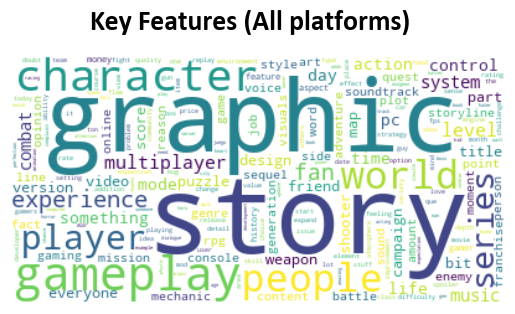

[('story', 4234.62), ('graphic', 3590.93), ('gameplay', 2945.34), ('character', 2696.43), ('people', 2167.66), ('world', 2153.97), ('player', 1789.08), ('series', 1722.52), ('experience', 1680.1), ('fan', 1556.14), ('multiplayer', 1515.69), ('level', 1486.44), ('combat', 1379.97), ('system', 1311.2), ('music', 1298.59), ('mode', 1184.44), ('action', 1170.87), ('day', 1147.25), ('something', 1084.58), ('time', 1083.95)]


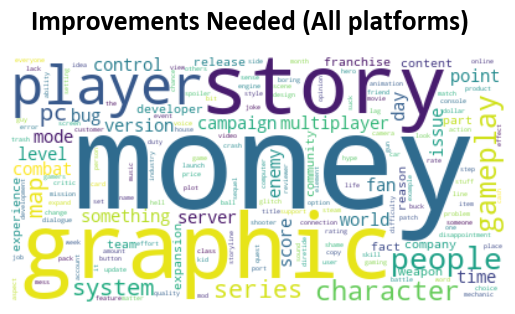

[('money', 813.66), ('graphic', 795.77), ('story', 790.71), ('player', 788.85), ('people', 725.03), ('gameplay', 633.71), ('character', 595.93), ('series', 473.55), ('map', 435.69), ('pc', 434.77), ('system', 434.51), ('multiplayer', 427.26), ('fan', 398.61), ('point', 394.77), ('something', 391.46), ('day', 383.94), ('bug', 383.53), ('server', 369.26), ('version', 358.12), ('level', 355.39)]
CPU times: total: 24min 30s
Wall time: 34min 55s


In [19]:
%%time

# Can adjust the parameters in this function to fine tune and iterate testings. Can adjust score bins, sample size and filter list above too!
# If ngrams = True, preProcessingFunctionBoolean needs to be True

for df in userCommentsTESTExtreme_list:
            if df.scoreBin.max() == 'High':
                features_improvements = 'Key Features'
            elif df.scoreBin.max() == 'Low':
                features_improvements = 'Improvements Needed'
            try:
                wc(df = df, columnName = 'Comment',
                preProcessingFunctionBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7,
                countVectorizerBinary = True, tfidfVectorizerBoolean = True,
                ngrams = False, ngramsNumber = 3, furtherPreProcessNgrams = False,
                nounTaggingBoolean = True, universalNounTagsetBoolean = False,
                top = 20, features_improvements = features_improvements, platform = 'All platforms', titleFontSize = 20)
            except ValueError:
                print(f"\n\nNo Word Cloud for '{features_improvements} (All platforms)' due to insufficient sample size (No. of comments = 0 or < vectorizerMinDf).\n\n")

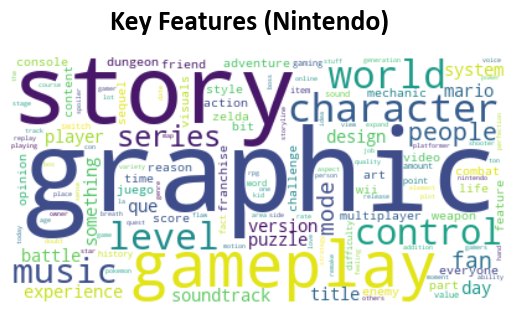

[('graphic', 525.02), ('story', 499.51), ('gameplay', 426.85), ('character', 400.7), ('world', 378.73), ('level', 344.73), ('control', 320.16), ('music', 308.94), ('series', 307.61), ('people', 280.65), ('fan', 238.14), ('mode', 225.24), ('experience', 217.63), ('player', 208.56), ('version', 205.16), ('system', 197.5), ('design', 192.34), ('day', 187.53), ('title', 177.95), ('mario', 174.35)]


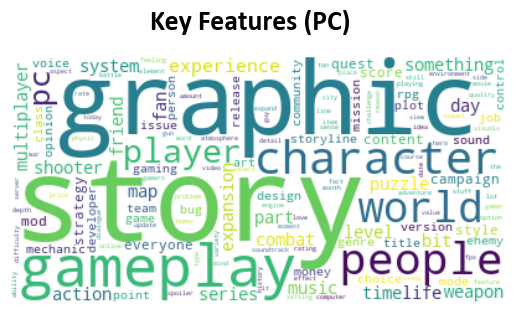

[('story', 1538.81), ('graphic', 1366.35), ('gameplay', 1050.34), ('character', 956.97), ('people', 905.54), ('world', 805.28), ('player', 771.16), ('pc', 676.35), ('experience', 636.82), ('combat', 556.82), ('level', 535.95), ('system', 517.42), ('multiplayer', 514.65), ('fan', 504.86), ('series', 477.56), ('day', 475.49), ('time', 443.99), ('map', 437.31), ('action', 436.35), ('life', 435.98)]


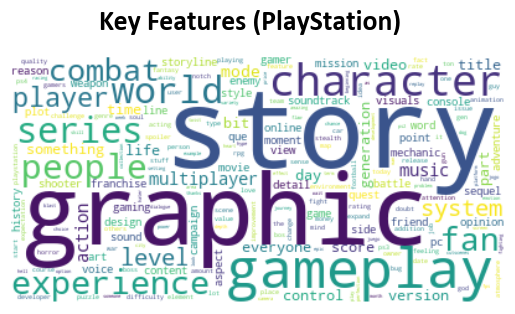

[('story', 1568.43), ('graphic', 1201.66), ('gameplay', 1051.84), ('character', 990.0), ('world', 693.94), ('series', 655.11), ('people', 631.61), ('experience', 578.87), ('fan', 544.83), ('combat', 514.58), ('player', 504.68), ('system', 431.04), ('level', 428.19), ('multiplayer', 424.97), ('action', 421.6), ('music', 412.79), ('mode', 382.48), ('time', 349.49), ('score', 336.64), ('life', 334.4)]


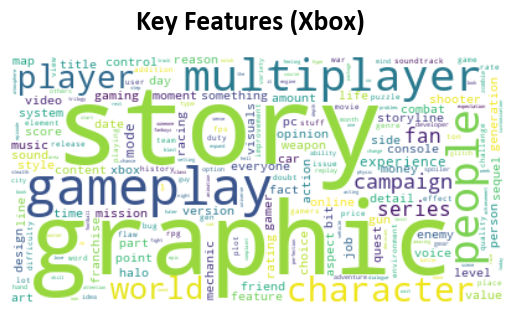

[('story', 693.73), ('graphic', 587.39), ('gameplay', 480.49), ('multiplayer', 432.95), ('people', 405.42), ('character', 397.89), ('player', 347.11), ('world', 328.69), ('campaign', 328.29), ('series', 308.88), ('fan', 302.73), ('experience', 285.77), ('mode', 273.73), ('shooter', 224.97), ('action', 216.63), ('xbox', 211.94), ('combat', 211.4), ('level', 209.7), ('system', 200.37), ('score', 199.54)]


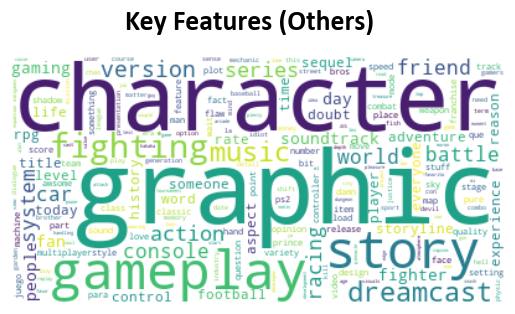

[('graphic', 17.31), ('character', 14.25), ('gameplay', 11.88), ('story', 11.36), ('fighting', 10.2), ('dreamcast', 9.23), ('music', 9.23), ('version', 6.29), ('action', 5.8), ('series', 5.72), ('friend', 5.36), ('battle', 5.29), ('console', 4.99), ('system', 4.98), ('world', 4.92), ('car', 4.9), ('racing', 4.86), ('fighter', 4.68), ('day', 4.67), ('people', 4.58)]


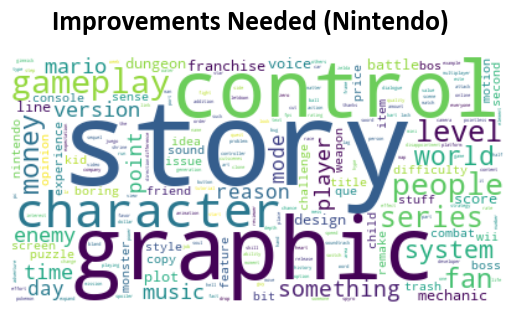

[('story', 35.78), ('graphic', 34.14), ('control', 31.09), ('character', 28.13), ('gameplay', 27.27), ('people', 22.93), ('level', 21.69), ('series', 19.47), ('money', 17.9), ('fan', 17.41), ('world', 16.58), ('system', 15.31), ('something', 14.4), ('music', 13.47), ('player', 13.17), ('enemy', 12.84), ('version', 12.82), ('time', 12.36), ('mario', 12.3), ('point', 11.02)]


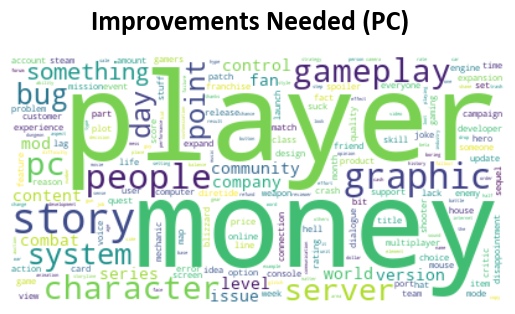

[('player', 448.28), ('money', 442.9), ('story', 401.7), ('graphic', 401.17), ('people', 374.77), ('character', 326.55), ('pc', 321.41), ('gameplay', 310.6), ('server', 279.59), ('system', 266.32), ('bug', 239.23), ('point', 228.5), ('day', 227.12), ('something', 208.37), ('community', 201.98), ('level', 195.42), ('fan', 195.15), ('issue', 194.22), ('series', 193.53), ('mod', 184.12)]


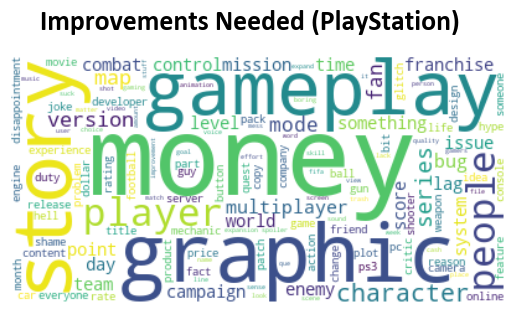

[('money', 210.43), ('graphic', 209.35), ('story', 209.26), ('gameplay', 186.42), ('player', 185.1), ('people', 183.91), ('character', 155.13), ('series', 129.1), ('map', 112.54), ('version', 112.42), ('mode', 105.51), ('fan', 100.01), ('multiplayer', 98.45), ('bug', 95.42), ('something', 94.7), ('system', 94.69), ('point', 89.91), ('control', 89.78), ('issue', 85.86), ('world', 85.74)]


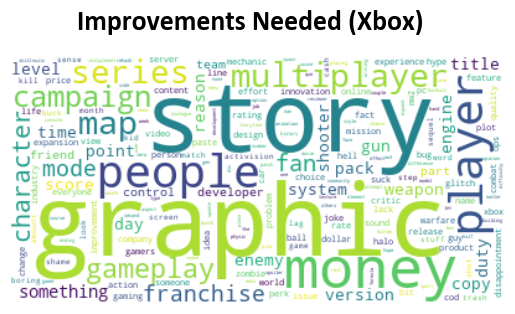

[('graphic', 180.66), ('story', 171.33), ('money', 170.54), ('people', 168.88), ('player', 167.37), ('multiplayer', 157.47), ('map', 155.4), ('series', 141.61), ('campaign', 133.27), ('gameplay', 130.64), ('character', 107.87), ('fan', 101.11), ('mode', 95.56), ('franchise', 93.3), ('something', 88.12), ('point', 78.77), ('weapon', 78.73), ('pack', 76.62), ('gun', 76.53), ('day', 74.85)]


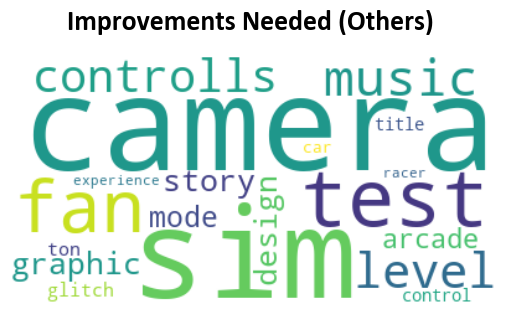

[('camera', 2.22), ('sim', 2.01), ('test', 2.0), ('fan', 1.63), ('music', 1.33), ('level', 1.21), ('controlls', 1.16), ('graphic', 1.05), ('design', 1.05), ('story', 1.03), ('mode', 0.89), ('arcade', 0.83), ('glitch', 0.83), ('ton', 0.83), ('title', 0.72), ('control', 0.72), ('car', 0.6), ('experience', 0.41), ('racer', 0.41)]
CPU times: total: 23min 59s
Wall time: 34min 51s


In [ ]:
%%time

# Can adjust the parameters in this function to fine tune and iterate testings. Can adjust score bins, sample size and filter list above too!
# If ngrams = True, preProcessingFunctionBoolean needs to be True

for df in userCommentsTESTExtreme_list:
    for platform in platformCondensed_list:
            if df.scoreBin.max() == 'High':
                features_improvements = 'Key Features'
            elif df.scoreBin.max() == 'Low':
                features_improvements = 'Improvements Needed'
            try:
                wc(df = df[df.platformCondensed == platform], columnName = 'Comment',
                preProcessingFunctionBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7,
                countVectorizerBinary = True, tfidfVectorizerBoolean = True,
                ngrams = False, ngramsNumber = 3, furtherPreProcessNgrams = False,
                nounTaggingBoolean = True, universalNounTagsetBoolean = False,
                top = 20, features_improvements = features_improvements, platform = platform, titleFontSize = 20)
            except ValueError:
                print(f"\n\nNo Word Cloud for '{features_improvements} ({platform})' due to insufficient sample size (No. of comments = 0 or < vectorizerMinDf).\n\n")

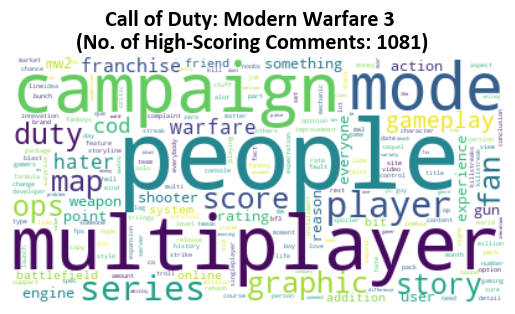

[('people', 62.55), ('multiplayer', 56.43), ('campaign', 47.65), ('mode', 43.12), ('player', 41.98), ('series', 37.77), ('graphic', 33.05), ('map', 32.1), ('fan', 31.93), ('score', 31.15), ('duty', 28.91), ('story', 28.37), ('ops', 28.37), ('gameplay', 25.83), ('cod', 22.6), ('hater', 20.64), ('warfare', 19.89), ('franchise', 19.78), ('something', 19.68), ('reason', 19.18)]


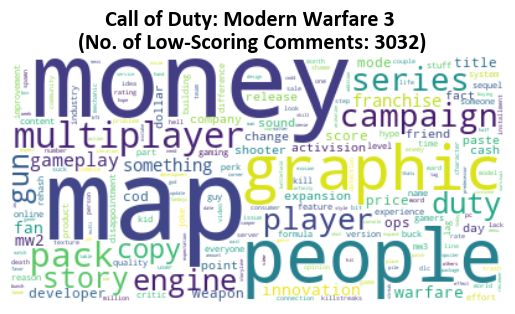

[('map', 131.48), ('money', 115.91), ('people', 102.68), ('graphic', 95.36), ('multiplayer', 95.14), ('pack', 87.91), ('series', 80.23), ('campaign', 78.78), ('player', 74.49), ('duty', 68.48), ('engine', 66.52), ('story', 61.3), ('gun', 60.41), ('copy', 58.94), ('gameplay', 58.32), ('something', 57.44), ('franchise', 56.63), ('fan', 51.64), ('innovation', 50.72), ('warfare', 50.17)]


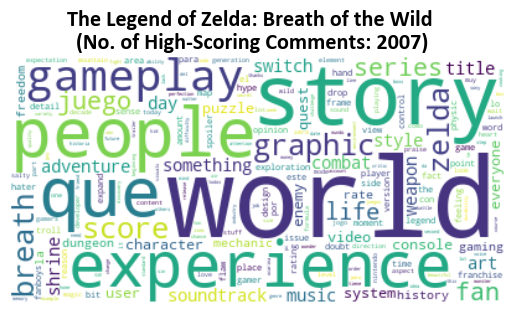

[('world', 124.74), ('story', 62.84), ('people', 54.37), ('que', 54.15), ('experience', 45.79), ('gameplay', 45.01), ('graphic', 43.12), ('breath', 41.41), ('score', 40.96), ('zelda', 39.88), ('series', 37.21), ('juego', 36.47), ('fan', 36.21), ('life', 33.4), ('something', 31.37), ('weapon', 29.68), ('music', 29.61), ('art', 29.34), ('adventure', 28.83), ('switch', 28.23)]


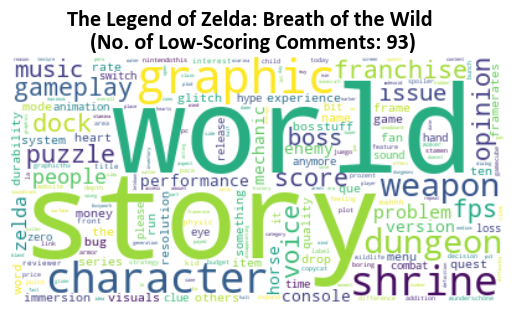

[('world', 5.4), ('story', 5.39), ('graphic', 4.59), ('character', 3.58), ('shrine', 3.39), ('dungeon', 3.35), ('weapon', 3.27), ('gameplay', 2.96), ('opinion', 2.83), ('fps', 2.73), ('score', 2.7), ('dock', 2.6), ('franchise', 2.57), ('puzzle', 2.56), ('voice', 2.46), ('boss', 2.29), ('music', 2.26), ('issue', 2.18), ('people', 2.06), ('problem', 2.05)]


In [ ]:
for game in ["Call of Duty: Modern Warfare 3", "The Legend of Zelda: Breath of the Wild"]:
    for df in userCommentsTESTExtreme_list:
        if df.scoreBin.max() == 'High':
            highLow = 'High'
            features_improvements = 'Key Features'
        elif df.scoreBin.max() == 'Low':
            highLow = 'Low'
            features_improvements = 'Improvements Needed'
        try:
            dynamic_value = df[df.Title == game].shape[0]
            static_phrase = "No. of {}-Scoring Comments: {}"
            noOfHighLowScoreComments = static_phrase.format(highLow, dynamic_value)

            gamePrint = game
            gameStatic = "{}\n"
            featuredGame = gameStatic.format(gamePrint)

            wc(df = df[df.Title == game], columnName = 'Comment',
            preProcessingFunctionBoolean = True, vectorizerMinDf = 2, vectorizerMaxDf = 0.7,
            countVectorizerBinary = True, tfidfVectorizerBoolean = True,
            ngrams = False, ngramsNumber = 3, furtherPreProcessNgrams = False,
            nounTaggingBoolean = True, universalNounTagsetBoolean = False,
            top = 20, features_improvements = featuredGame, platform = noOfHighLowScoreComments, titleFontSize = 16)
        except ValueError:
            print(f"\n\nNo Word Cloud for '{game}, ({highLow} Score)' due to insufficient sample size (No. of comments = 0 or < vectorizerMinDf).\n\n")

### 6. Convert and Merge DTM as Structured Data

In [16]:
# From createMainTable.py!!!! (Pulling var from other file doesn't seem to work, dk why)

# 65 (0.07%) games have > 1 release date on same platform .. take the LATEST date!
gameScore_nodup = gameScore[['name', 'platform', 'release_date']].sort_values(by = ['name', 'platform', 'release_date']).drop_duplicates(keep = 'last')
a = gameScore_nodup[(gameScore_nodup.duplicated(subset=['name', 'platform'],keep = False))].sort_values(by = ['name', 'platform']).name.nunique()
# print(f'{a} out of {gameScore.name.nunique()}: {round(a/gameScore.name.nunique()*100, 2)}%')

gameScore_final = gameScore[['name', 'platform', 'release_date']].sort_values(by = ['name', 'platform', 'release_date']).drop_duplicates(subset = ['name', 'platform'], keep = 'last')
gameScore.shape
gameScore_final.shape
main.platform.unique()
gameScore_final.platform.unique()
platformMap = {
'iOS': 'iOS',
'iOS (Apple Arcade)': 'iOS',
'PC': 'PC',
'PlayStation 4': 'PS4',
'PlayStation 5': 'PS5',
'Switch': 'Switch', # no mapping
'Xbox One': 'Xbox One', # no mapping
'Xbox Series X': 'Xbox Series X',
}

gameScore_final['platform'] = gameScore_final.platform.map(platformMap)
gameScore_final.platform.unique()
main.drop(columns= 'releasedate_1986-2023', inplace = True)
gameScore_final.rename(columns = {'release_date': 'releasedate_1986-2023', 'name': 'title'}, inplace = True)

mainDf = pd.merge(main, gameScore_final, how = 'left', on = ['title', 'platform'])
# Only 1421 release dates from 1986-2023 file can be mapped to main table (using title and platform as matching keys)!

mainDf['releasedate_1986-2023'].count()
mainDf.shape
# mainDf.head()

(8896, 25)

In [17]:
userComments.shape

(283983, 5)

In [18]:
# From dataProcessing.py!!!! (Pulling var from other file doesn't seem to work, dk why)

platformMap = {
'DS': 'DS',
'iOS': 'iOS',
'PC': 'PC',
'PlayStation': 'PS',
'PlayStation2': 'PS2',
'PlayStation3': 'PS3',
'PlayStation4': 'PS4',
'PlayStation5': 'PS5'
}

userComments['Platform_alignedNaming'] = userComments.Platform.map(platformMap)
userComments.loc[userComments.Platform_alignedNaming == 'not specified', 'Platform_alignedNaming'] = np.NaN

In [30]:
%%time

filter_list = ["would", "could", "left", "right", "a.m.", "p.m.", "'s", "! ! !", "...", ":", ";", "n't",
              "game", "games", "much", "one", "time", "year", "lot", "thing", "etc", "hour", "hours", 
              "way", "ways", "everything", "anything", "thing", "things", "review", "reviews", "year", "years",
              "feel", "feels", "thing", "kind", "call", "anyone", "minute", "minutes"]

# noun_list = []
# for value in userComments['Comment']:
#     tagged_value = pos_tag(word_tokenize(value))
#     noun = [word for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']
# noun_list.append(noun)
# userComments['Text_NounOnly'] = noun_list
# userComments['Text_NounOnly'] = userComments['Text_NounOnly'].apply(lambda x: preprocess_text(tokens = x, needtokenizeBoolean = False))
# userComments['Text_NounOnly'] = userComments['Text_NounOnly'].apply(lambda x: ', '.join(x))

tdm = TfidfVectorizer(tokenizer = preprocess_text, min_df = 2, max_df = 0.7)
tfidf_dtm = tdm.fit_transform(userComments[userComments.Comment.notnull()].Comment)

tfidf_dtm

CPU times: total: 3h 55min 33s
Wall time: 4h 53min 4s


<283960x146842 sparse matrix of type '<class 'numpy.float64'>'
	with 13732592 stored elements in Compressed Sparse Row format>

In [47]:
n_components = 100  # This no. must be the same or smaller than the no. of rows!! Typically set between 100 to 300
svd = TruncatedSVD(n_components=n_components)
tfidf_reduced = svd.fit_transform(tfidf_dtm)
tfidf_df = pd.DataFrame(tfidf_reduced, columns=[f'component_{i}' for i in range(n_components)])

userCommentsStructured = userComments[['Title', 'Platform_alignedNaming', 'Userscore']][userComments.Comment.notnull()].join(tfidf_df)
userCommentsStructuredCondensed = userCommentsStructured.groupby(['Title', 'Platform_alignedNaming']).mean().reset_index()
userCommentsStructuredCondensed.rename(columns = {'Title': 'title', 'Platform_alignedNaming': 'platform'}, inplace = True)

userCommentsSales = pd.merge(mainDf, userCommentsStructuredCondensed, how = 'left', on = ['title', 'platform'])

In [59]:
userCommentsSales.shape

(8896, 126)

In [48]:
userCommentsSales.to_csv('userCommentsSales.csv', index=False)